# MIPD of warfarin

In [1]:
import os
import string

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import myokit
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()

from model import define_wajima_model

Define convenience functions

In [2]:
def get_vk_consumption(days, nids, seed):
    """
    Returns deviations of the vk consumption from the mean consumption drawn
    from a normal distribution of shape (days, n_ids).
    """
    rng = np.random.default_rng(seed)
    vk_input = rng.normal(loc=1, scale=0.1, size=(days, nids))

    return vk_input


def define_dosing_regimen(doses, delays, cal_time=100*24):
    """
    Returns a dosing regimen with delayed administration times.
    """
    duration = 0.01
    regimen = myokit.Protocol()
    for day, dose in enumerate(doses):
        if dose == 0:
            continue
        regimen.add(myokit.ProtocolEvent(
            level=dose/duration,
            start=cal_time+day*24+delays[day],
            duration=duration))

    return regimen

## Visualise demographics of trial cohort

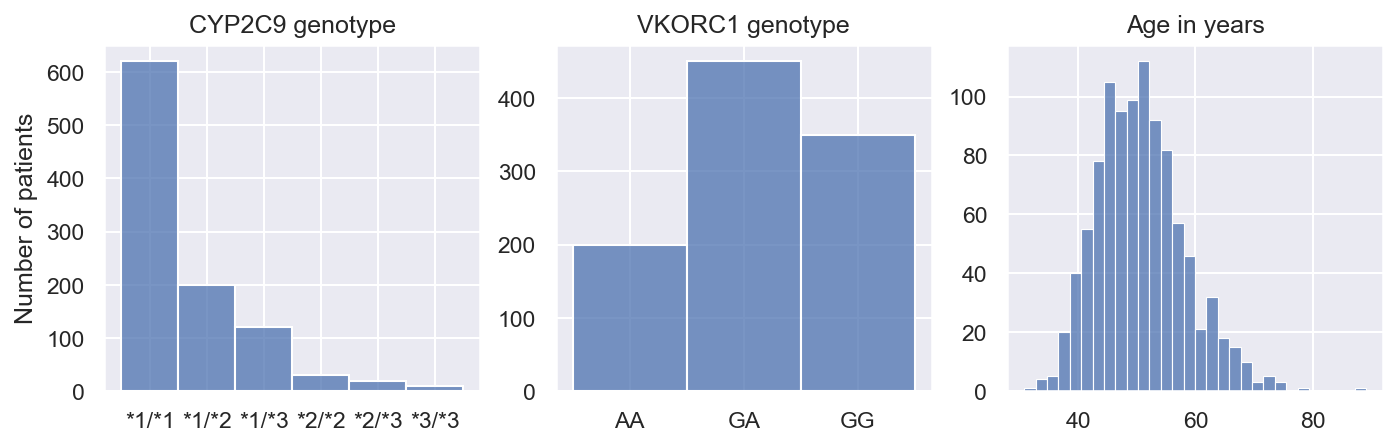

In [3]:
# Import data
directory = os.path.dirname(os.getcwd())
df_demo = pd.read_csv(directory + '/data/mipd_trial_cohort.csv')

# Reshape data
ids = df_demo.ID.dropna().unique()
cyp = []
vkorc = []
age = np.empty(len(ids))
cyp_decoder = {
    0: '*1/*1', 1: '*1/*2', 2: '*1/*3', 3: '*2/*2', 4: '*2/*3', 5: '*3/*3'}
vkorc_decoder = {0: 'GG', 1: 'GA', 2: 'AA'}
for idx, _id in enumerate(ids):
    temp = df_demo[df_demo.ID == _id]
    cyp.append(cyp_decoder[int(temp['CYP2C9'].values)])
    vkorc.append(vkorc_decoder[int(temp['VKORC1'].values)])
    age[idx] = temp['Age'].values
cyp.sort()
vkorc.sort()

# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, hspace=2.5)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot CYP2C9 distribution
sns.histplot(cyp, ax=axes[0])
sns.histplot(vkorc, ax=axes[1])
sns.histplot(age, ax=axes[2])

# Label axes
titles = ['CYP2C9 genotype', 'VKORC1 genotype', 'Age in years']
ylabels = ['Number of patients', '', '']
for ida, ax in enumerate(axes):
    ax.set_title(titles[ida])
    ax.set_ylabel(ylabels[ida])

plt.savefig('7_mipd_trial_demographics.pdf', bbox_inches='tight')
plt.savefig('7_mipd_trial_demographics.tif', bbox_inches='tight')

plt.show()

## Evaluate regression model

Simulate INR response for predicted dosing regimens

In [23]:
# Define model
model, _ = define_wajima_model(patient=True, inr_test=True)

# Get patient parameters
ids = df_demo.ID.dropna().unique()
parameters = np.empty(shape=(len(ids), model.n_parameters()))
for idx, _id in enumerate(ids):
    temp = df_demo[df_demo.ID == _id]
    parameters[idx] = temp[model.parameters()].values[0]

# Load dosing strategy
directory = os.path.dirname(os.getcwd())
df_doses = pd.read_csv(
    directory + '/3_regression_model'
    '/mipd_trial_predicted_dosing_regimens_deep_regression.csv')

# Convert dosing strategy to dosing regimens
# The induction doses are fixed to 10, 5 on days 1 and 2
days = 19
cal_time = 100 * 24
duration = 0.01
dosing_regimens = {}
doses = np.empty(shape=(len(df_doses.ID.dropna().unique()), days))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    temp = df_doses[df_doses.ID == _id]
    doses[idx] = np.array(
        [10, 7.5, 5]
        + [temp['Maintenance dose'].values[0]] * (days-3))

# Define IOV and EV
ids = df_doses.ID.dropna().unique()
rng = np.random.default_rng(seed=4)
delays = rng.exponential(scale=0.5, size=(days, len(ids)))
vk_input = get_vk_consumption(days, len(ids), seed=14)

# Simulate INR response to treatment
times = cal_time + np.linspace(0, days, 100, endpoint=False) * 24
inrs_1 = np.empty(shape=(len(ids), len(times)))
for idx, _id in enumerate(ids):
    # Set dosing regimen
    dr = define_dosing_regimen(doses[idx], delays=delays[:, idx])
    model.set_dosing_regimen(dr)

    # Simulate treatment response
    mask = ids == _id
    inrs_1[idx] = model.simulate(
        parameters=parameters[mask][0], times=times, vk_input=vk_input[:, idx])

Visualise treatment response

/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


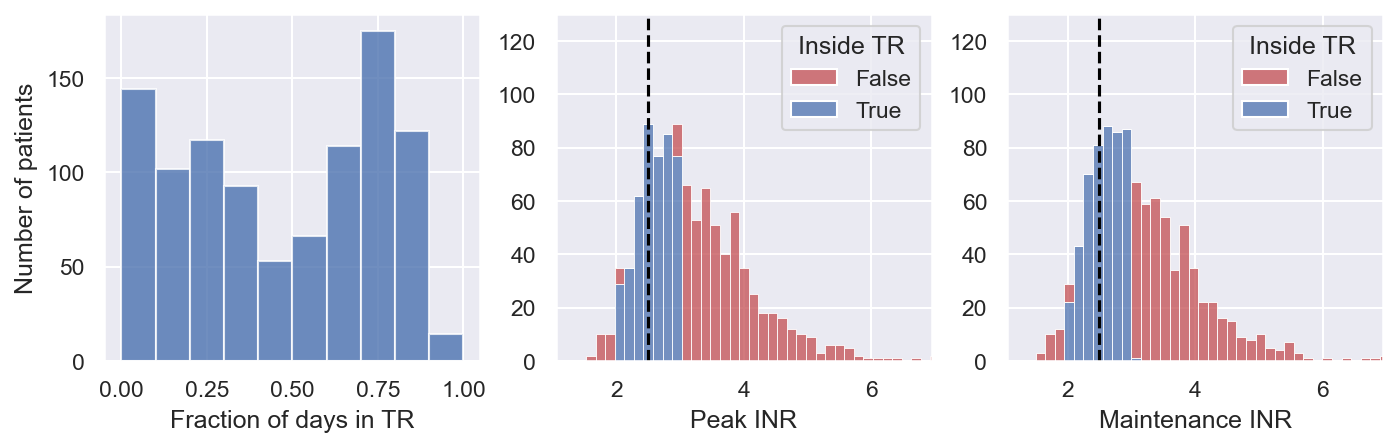

In [24]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, hspace=2.5)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
in_tr = (inrs_1 >= 2) & (inrs_1 <= 3)
ttr = np.mean(in_tr, axis=1)
axes[0].hist(
    ttr, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    color=sns.color_palette()[0], alpha=0.8)

# Plot distribution of peak INR
max_inrs = np.max(inrs_1, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[1], multiple='stack',binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[1].axvline(x=2.5, color='black', linestyle='dashed')

# # Plot maintenance INR distirbution
final_inrs = inrs_1[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[2], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[2].axvline(x=2.5, color='black', linestyle='dashed')


# Label axes
axes[0].set_xlabel('Fraction of days in TR')
axes[0].set_ylabel('Number of patients')
axes[0].set_xlim([-0.05, 1.05])
axes[1].set_xlabel('Peak INR')
axes[1].set_ylabel('')
axes[1].set_xlim([1.05, 6.95])
axes[1].set_ylim([0, 130])
axes[2].set_xlabel('Maintenance INR')
axes[2].set_ylabel('')
axes[2].set_xlim([1.05, 6.95])
axes[2].set_ylim([0, 130])

plt.savefig('7_mipd_trial_results_deep_regression.pdf', bbox_inches='tight')
plt.savefig('7_mipd_trial_results_deep_regression.tif', bbox_inches='tight')

plt.show()

Visualise dosing regimens

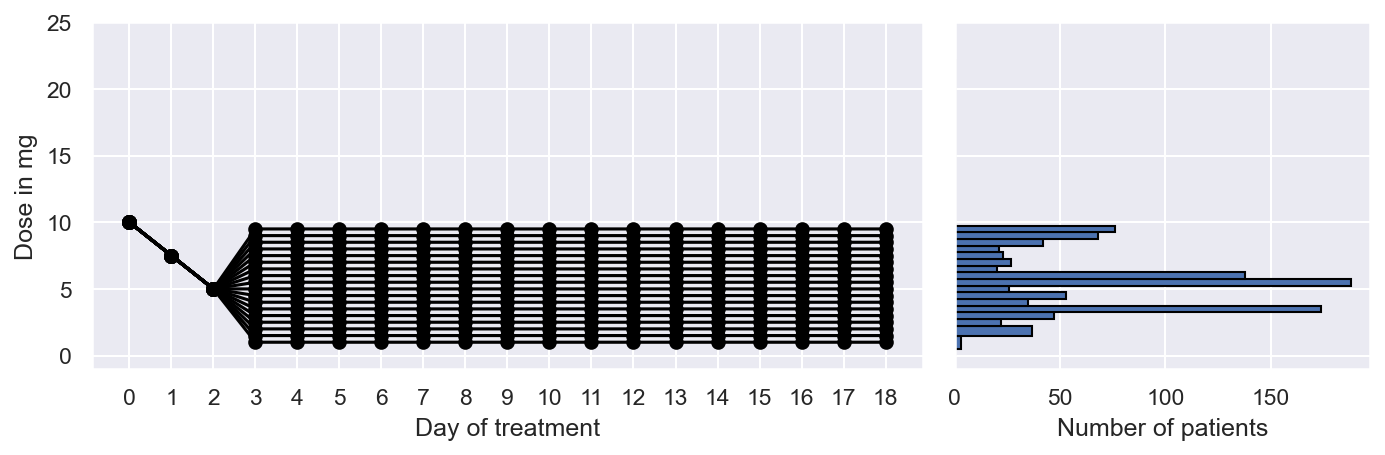

In [25]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[2, 1])

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
maintenance_dose = {}
for d in doses:
    if str(d[-1]) in maintenance_dose.keys():
        maintenance_dose[str(d[-1])] += 1
        continue
    axes[0].plot(np.arange(days), d, marker='o', color='black')
    maintenance_dose[str(d[-1])] = 1
axes[1].hist(
    x=doses[:, -1],
    color=sns.color_palette()[0],
    orientation='horizontal',
    edgecolor='black',
    bins=[
        0, 0.5, 1.5, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75,
        6.25, 6.75, 7.25, 7.75, 8.25, 8.75, 9.25, 9.75, 10.25, 10.75, 11.25,
        11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75, 15.25, 15.75, 16.25,
        16.75, 17.25, 17.75, 18.25, 18.75, 19.25, 19.75, 20.25, 20.75, 21.25,
        21.75, 22.25])

# Label axes
axes[0].set_xlabel('Day of treatment')
axes[0].set_ylabel('Dose in mg')
axes[0].set_ylim([-1, 25])
axes[0].set_xticks(list(range(days)))
axes[1].set_xlabel('Number of patients')
axes[1].set_yticklabels(labels=[], visible=False)
axes[1].set_ylim([-1, 25])
axes[1].set_ylabel('')

plt.show()

## Evaluate PKPD model (covariates only)

Simulate INR response for predicted dosing regimens

In [26]:
# Define model
model, _ = define_wajima_model(patient=True, inr_test=True)

# Get patient parameters
ids = df_demo.ID.dropna().unique()
parameters = np.empty(shape=(len(ids), model.n_parameters()))
for idx, _id in enumerate(ids):
    temp = df_demo[df_demo.ID == _id]
    parameters[idx] = temp[model.parameters()].values[0]

# Load dosing strategy
directory = os.path.dirname(os.getcwd())
df_doses = pd.read_csv(
    directory + '/2_semi_mechanistic_model'
    '/mipd_trial_predicted_dosing_regimens.csv')
df_doses = df_doses[df_doses['Number of observations'] == 0]

# Convert dosing strategy to dosing regimens
# The induction doses are fixed to 10, 5 on days 1 and 2
days = 19
cal_time = 100 * 24
duration = 0.01
dosing_regimens = {}
doses = np.empty(shape=(len(df_doses.ID.dropna().unique()), days))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    temp = df_doses[df_doses.ID == _id]
    doses[idx] = \
        temp[['Dose %d in mg' % (idx+1) for idx in range(days)]].values[0]

# Define IOV and EV
ids = df_doses.ID.dropna().unique()
rng = np.random.default_rng(seed=4)
delays = rng.exponential(scale=0.5, size=(days, len(ids)))
vk_input = get_vk_consumption(days, len(ids), seed=14)

# Simulate INR response to treatment
times = cal_time + np.linspace(0, days, 100, endpoint=False) * 24
inrs_2 = np.empty(shape=(len(ids), len(times)))
for idx, _id in enumerate(ids):
    # Set dosing regimen
    dr = define_dosing_regimen(doses[idx], delays=delays[:, idx])
    model.set_dosing_regimen(dr)

    # Simulate treatment response
    mask = ids == _id
    inrs_2[idx] = model.simulate(
        parameters=parameters[mask][0], times=times, vk_input=vk_input[:, idx])

Visualise treatment response

/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


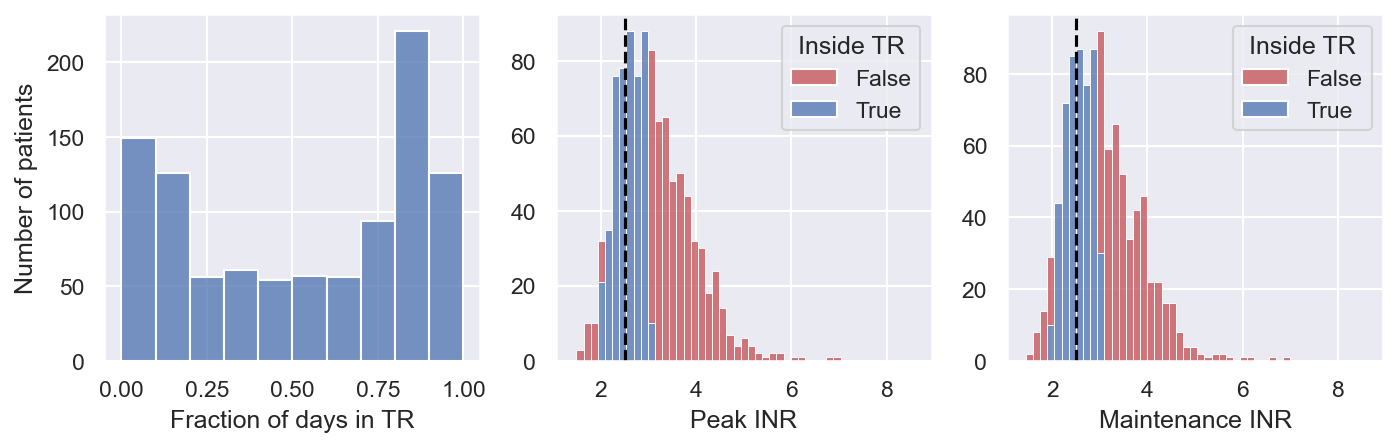

In [27]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, hspace=2.5)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
in_tr = (inrs_2 >= 2) & (inrs_2 <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[0], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot distribution of peak INR
max_inrs = np.max(inrs_2, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[1], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[1].axvline(x=2.5, color='black', linestyle='dashed')

# # Plot maintenance INR distirbution
final_inrs = inrs_2[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[2], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[2].axvline(x=2.5, color='black', linestyle='dashed')


# Label axes
axes[0].set_xlabel('Fraction of days in TR')
axes[0].set_ylabel('Number of patients')
axes[0].set_xlim([-0.05, 1.05])
axes[1].set_xlabel('Peak INR')
axes[1].set_ylabel('')
axes[1].set_xlim([1.05, 8.95])
axes[2].set_xlabel('Maintenance INR')
axes[2].set_ylabel('')
axes[2].set_xlim([1.05, 8.95])

plt.savefig(
    '8_mipd_trial_results_pkpd_model_covariates_only.pdf', bbox_inches='tight')
plt.savefig(
    '8_mipd_trial_results_pkpd_model_covariates_only.tif', bbox_inches='tight')

plt.show()

Visualise dosing regimens

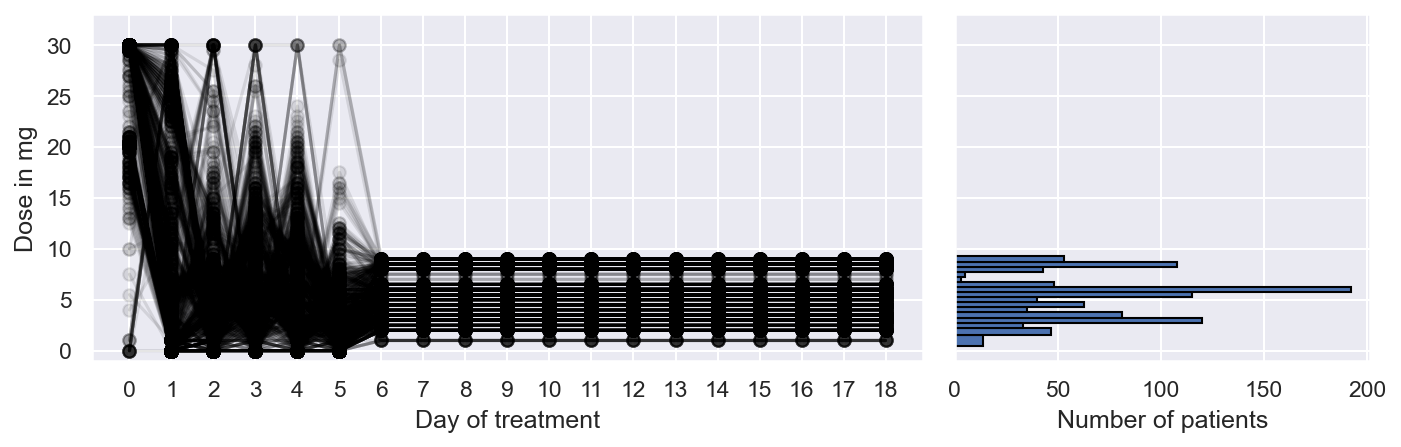

In [28]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[2, 1])

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
maintenance_dose = {}
for d in doses:
    axes[0].plot(np.arange(days), d, marker='o', color='black', alpha=0.1)
    maintenance_dose[str(d[-1])] = 1
axes[1].hist(
    x=doses[:, -1],
    color=sns.color_palette()[0],
    orientation='horizontal',
    edgecolor='black',
    bins=[
        0, 0.5, 1.5, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75,
        6.25, 6.75, 7.25, 7.75, 8.25, 8.75, 9.25, 9.75, 10.25, 10.75, 11.25,
        11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75, 15.25, 15.75])

# Label axes
axes[0].set_xlabel('Day of treatment')
axes[0].set_ylabel('Dose in mg')
axes[0].set_ylim([-1, 33])
axes[0].set_xticks(list(range(days)))
axes[1].set_xlabel('Number of patients')
axes[1].set_yticklabels(labels=[], visible=False)
axes[1].set_ylim([-1, 33])
axes[1].set_ylabel('')

plt.show()

## Evaluate DQN model

In [29]:
model, _ = define_wajima_model(patient=True, inr_test=True)

# Get patient parameters
ids = df_demo.ID.dropna().unique()
parameters = np.empty(shape=(len(ids), model.n_parameters()))
for idx, _id in enumerate(ids):
    temp = df_demo[df_demo.ID == _id]
    parameters[idx] = temp[model.parameters()].values[0]

# Load dosing strategy
directory = os.path.dirname(os.getcwd())
data = pd.read_csv(
    directory + '/4_reinforcement_learning'
    '/mipd_trial_predicted_dosing_regimens.csv')
df_doses = data[data['Number of observations'] == 19]

# Convert dosing strategy to dosing regimens
days = 19
cal_time = 100 * 24
duration = 0.01
dosing_regimens = {}
doses = np.empty(shape=(len(df_doses.ID.dropna().unique()), days))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    temp = df_doses[df_doses.ID == _id]
    doses[idx] = \
        temp[['Dose %d in mg' % (idx+1) for idx in range(days)]].values[0]

# Define IOV and EV
ids = df_doses.ID.dropna().unique()
rng = np.random.default_rng(seed=4)
delays = rng.exponential(scale=0.5, size=(days, len(ids)))
vk_input = get_vk_consumption(days, len(ids), seed=14)

# Simulate INR response to treatment
times = cal_time + np.linspace(0, days, 100, endpoint=False) * 24
inrs_3 = np.empty(shape=(len(ids), len(times)))
for idx, _id in enumerate(ids):
    # Set dosing regimen
    dr = define_dosing_regimen(doses[idx], delays=delays[:, idx])
    model.set_dosing_regimen(dr)

    # Simulate treatment response
    mask = ids == _id
    inrs_3[idx] = model.simulate(
        parameters=parameters[mask][0], times=times, vk_input=vk_input[:, idx])

# Filter those individuals with INR measurements above 7.5
excluded = data[data.INR > 7.5].ID.dropna().unique()
temp = np.empty((inrs_3.shape[0] - len(excluded), inrs_3.shape[1]))
idx = 0
for _id, inrs in enumerate(inrs_3):
    if ids[_id] in excluded:
        continue
    temp[idx] = inrs
    idx += 1

inrs_3 = temp

Visualise treatment response

/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


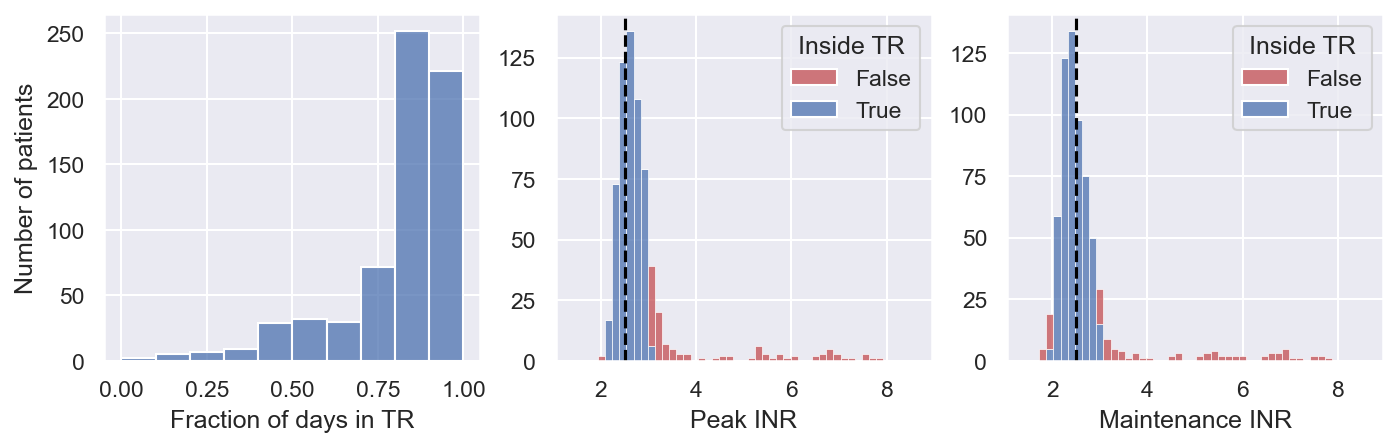

In [30]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, hspace=2.5)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
in_tr = (inrs_3 >= 2) & (inrs_3 <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[0], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot distribution of peak INR
max_inrs = np.max(inrs_3, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[1], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[1].axvline(x=2.5, color='black', linestyle='dashed')

# # Plot maintenance INR distirbution
final_inrs = inrs_3[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[2], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[2].axvline(x=2.5, color='black', linestyle='dashed')

# Label axes
axes[0].set_xlabel('Fraction of days in TR')
axes[0].set_ylabel('Number of patients')
axes[0].set_xlim([-0.05, 1.05])
axes[1].set_xlabel('Peak INR')
axes[1].set_ylabel('')
axes[1].set_xlim([1.05, 8.95])
axes[2].set_xlabel('Maintenance INR')
axes[2].set_ylabel('')
axes[2].set_xlim([1.05, 8.95])

plt.savefig(
    '9_mipd_trial_results_dqn.pdf', bbox_inches='tight')
plt.savefig(
    '9_mipd_trial_results_dqn.tif', bbox_inches='tight')

plt.show()

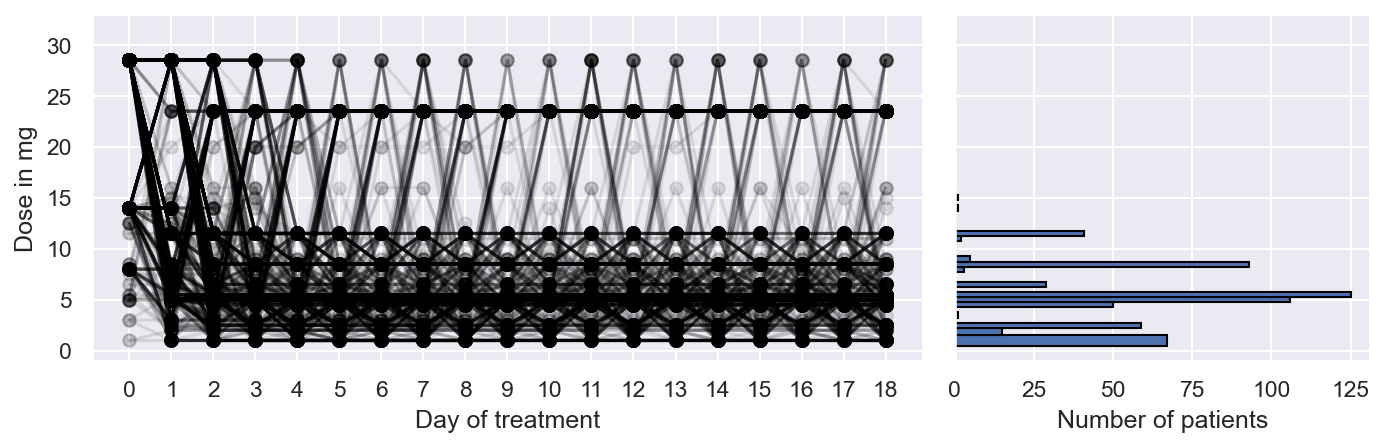

In [31]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[2, 1])

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
maintenance_dose = {}
for d in doses:
    axes[0].plot(np.arange(days), d, marker='o', color='black', alpha=0.1)
    maintenance_dose[str(d[-1])] = 1
axes[1].hist(
    x=doses[:, -1],
    color=sns.color_palette()[0],
    orientation='horizontal',
    edgecolor='black',
    bins=[
        0, 0.5, 1.5, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75,
        6.25, 6.75, 7.25, 7.75, 8.25, 8.75, 9.25, 9.75, 10.25, 10.75, 11.25,
        11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75, 15.25, 15.75])

# Label axes
axes[0].set_xlabel('Day of treatment')
axes[0].set_ylabel('Dose in mg')
axes[0].set_ylim([-1, 33])
axes[0].set_xticks(list(range(days)))
axes[1].set_xlabel('Number of patients')
axes[1].set_yticklabels(labels=[], visible=False)
axes[1].set_ylim([-1, 33])
axes[1].set_ylabel('')

plt.show()

Visualise demographics of excluded patients

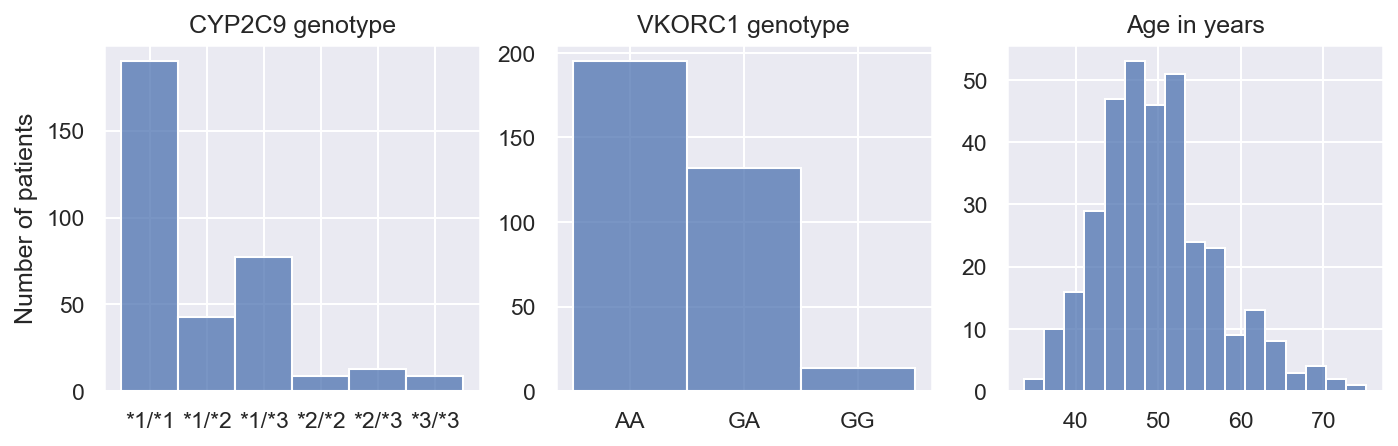

In [10]:
# Reshape data
ids = df_demo.ID.dropna().unique()
cyp = []
vkorc = []
age = np.empty(len(excluded))
cyp_decoder = {
    0: '*1/*1', 1: '*1/*2', 2: '*1/*3', 3: '*2/*2', 4: '*2/*3', 5: '*3/*3'}
vkorc_decoder = {0: 'GG', 1: 'GA', 2: 'AA'}
idx = 0
for _id in ids:
    if _id in excluded:
        temp = df_demo[df_demo.ID == _id]
        cyp.append(cyp_decoder[int(temp['CYP2C9'].values)])
        vkorc.append(vkorc_decoder[int(temp['VKORC1'].values)])
        age[idx] = temp['Age'].values
        idx += 1
cyp.sort()
vkorc.sort()

# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, hspace=2.5)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot CYP2C9 distribution
sns.histplot(cyp, ax=axes[0])
sns.histplot(vkorc, ax=axes[1])
sns.histplot(age, ax=axes[2])

# Label axes
titles = ['CYP2C9 genotype', 'VKORC1 genotype', 'Age in years']
ylabels = ['Number of patients', '', '']
for ida, ax in enumerate(axes):
    ax.set_title(titles[ida])
    ax.set_ylabel(ylabels[ida])

plt.savefig(
    '9_mipd_trial_demographics_dqn_excluded.pdf', bbox_inches='tight')
plt.savefig(
    '9_mipd_trial_demographics_dqn_excluded.tif', bbox_inches='tight')

plt.show()

Dosing strategy

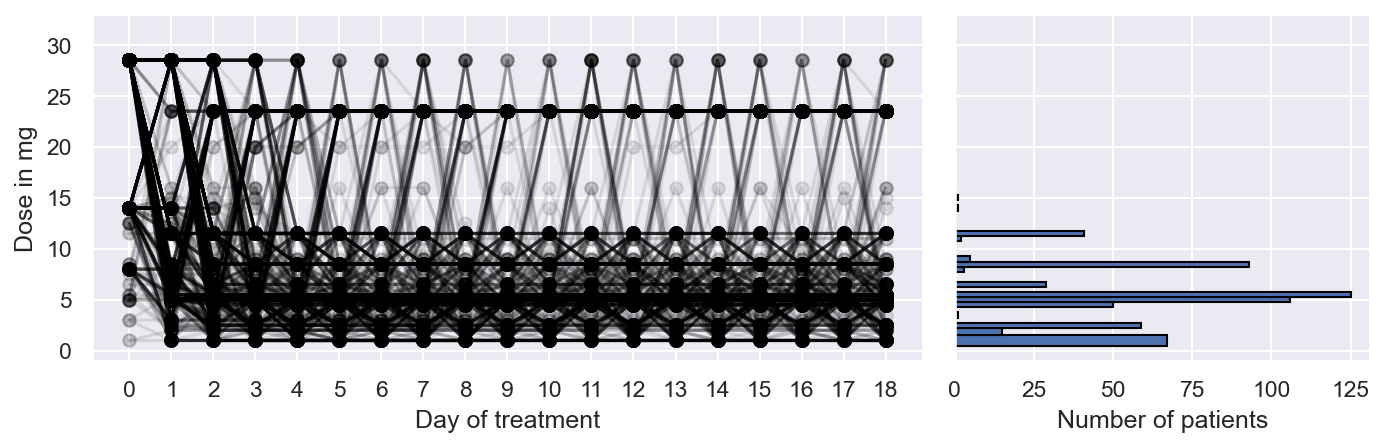

In [296]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[2, 1])

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
maintenance_dose = {}
for d in doses:
    axes[0].plot(np.arange(days), d, marker='o', color='black', alpha=0.1)
    maintenance_dose[str(d[-1])] = 1
axes[1].hist(
    x=doses[:, -1],
    color=sns.color_palette()[0],
    orientation='horizontal',
    edgecolor='black',
    bins=[
        0, 0.5, 1.5, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75,
        6.25, 6.75, 7.25, 7.75, 8.25, 8.75, 9.25, 9.75, 10.25, 10.75, 11.25,
        11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75, 15.25, 15.75])

# Label axes
axes[0].set_xlabel('Day of treatment')
axes[0].set_ylabel('Dose in mg')
axes[0].set_ylim([-1, 33])
axes[0].set_xticks(list(range(days)))
axes[1].set_xlabel('Number of patients')
axes[1].set_yticklabels(labels=[], visible=False)
axes[1].set_ylim([-1, 33])
axes[1].set_ylabel('')

plt.show()

## Evaluate PKPD model (Bayesian dosing regimen optimisation)

In [19]:
# Define model
model, _ = define_wajima_model(patient=True, inr_test=True)

# Get patient parameters
ids = df_demo.ID.dropna().unique()
parameters = np.empty(shape=(len(ids), model.n_parameters()))
for idx, _id in enumerate(ids):
    temp = df_demo[df_demo.ID == _id]
    parameters[idx] = temp[model.parameters()].values[0]

# Load dosing strategy
directory = os.path.dirname(os.getcwd())
df_doses = pd.read_csv(
    directory + '/2_semi_mechanistic_model'
    '/mipd_trial_predicted_dosing_regimens.csv')
df_doses = df_doses[df_doses['Number of observations'] == 19]

# Convert dosing strategy to dosing regimens
days = 19
cal_time = 100 * 24
duration = 0.01
dosing_regimens = {}
doses = np.empty(shape=(len(df_doses.ID.dropna().unique()), days))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    temp = df_doses[df_doses.ID == _id]
    doses[idx] = \
        temp[['Dose %d in mg' % (idx+1) for idx in range(days)]].values[0]

# Define IOV and EV
ids = df_doses.ID.dropna().unique()
rng = np.random.default_rng(seed=4)
delays = rng.exponential(scale=0.5, size=(days, len(ids)))
vk_input = get_vk_consumption(days, len(ids), seed=14)

# Simulate INR response to treatment
times = cal_time + np.linspace(0, days, 100, endpoint=False) * 24
inrs_4 = np.empty(shape=(len(ids), len(times)))
for idx, _id in enumerate(ids):
    # Set dosing regimen
    dr = define_dosing_regimen(doses[idx], delays=delays[:, idx])
    model.set_dosing_regimen(dr)

    # Simulate treatment response
    mask = ids == _id
    inrs_4[idx] = model.simulate(
        parameters=parameters[mask][0], times=times, vk_input=vk_input[:, idx])

Visualise treatment response

/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


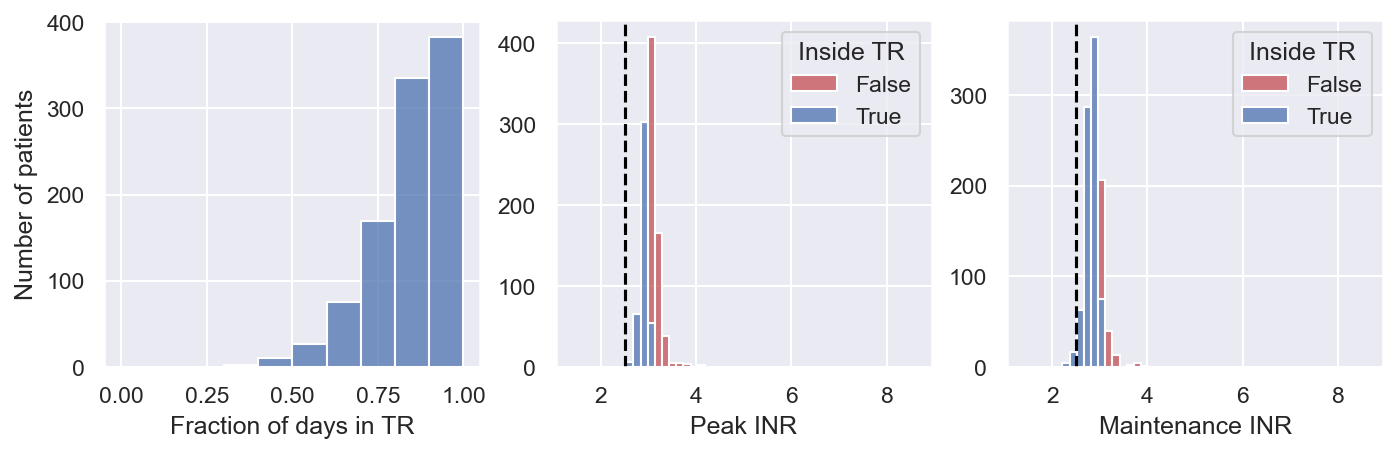

In [20]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, hspace=2.5)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
in_tr = (inrs_4 >= 2) & (inrs_4 <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[0], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot distribution of peak INR
max_inrs = np.max(inrs_4, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[1], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[1].axvline(x=2.5, color='black', linestyle='dashed')

# # Plot maintenance INR distirbution
final_inrs = inrs_4[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[2], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[2].axvline(x=2.5, color='black', linestyle='dashed')


# Label axes
axes[0].set_xlabel('Fraction of days in TR')
axes[0].set_ylabel('Number of patients')
axes[0].set_xlim([-0.05, 1.05])
axes[1].set_xlabel('Peak INR')
axes[1].set_ylabel('')
axes[1].set_xlim([1.05, 8.95])
axes[2].set_xlabel('Maintenance INR')
axes[2].set_ylabel('')
axes[2].set_xlim([1.05, 8.95])

# plt.savefig(
#     '10_mipd_trial_results_pkpd_model_BDRO_7_tdm.pdf', bbox_inches='tight')
# plt.savefig(
#     '10_mipd_trial_results_pkpd_model_BDRO_7_tdm.tif', bbox_inches='tight')

plt.show()

Dosing strategy

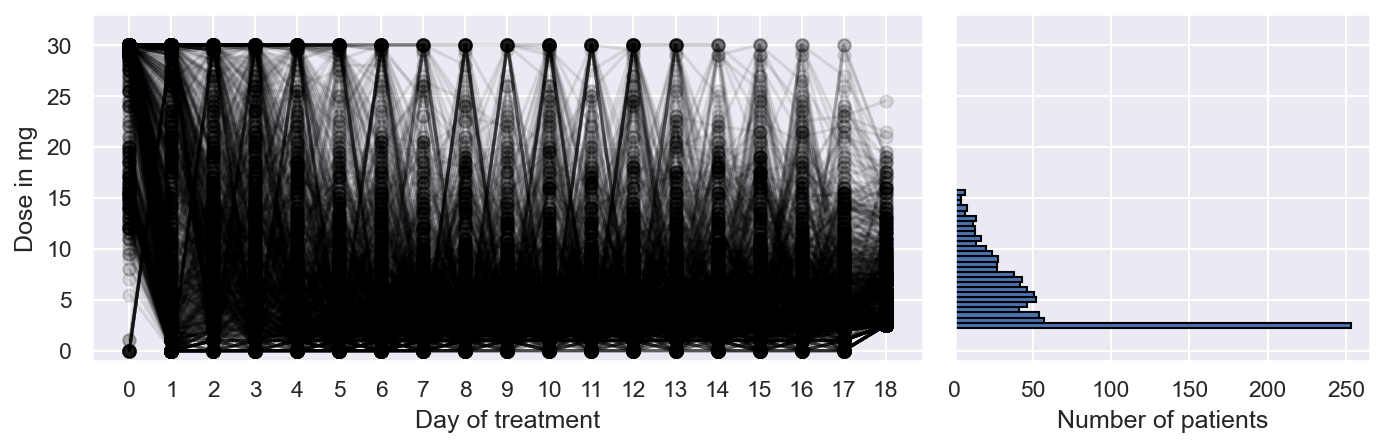

In [21]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[2, 1])

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
maintenance_dose = {}
for d in doses:
    axes[0].plot(np.arange(days), d, marker='o', color='black', alpha=0.1)
    maintenance_dose[str(d[-1])] = 1
axes[1].hist(
    x=doses[:, -1],
    color=sns.color_palette()[0],
    orientation='horizontal',
    edgecolor='black',
    bins=[
        0, 0.5, 1.5, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75,
        6.25, 6.75, 7.25, 7.75, 8.25, 8.75, 9.25, 9.75, 10.25, 10.75, 11.25,
        11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75, 15.25, 15.75])

# Label axes
axes[0].set_xlabel('Day of treatment')
axes[0].set_ylabel('Dose in mg')
axes[0].set_ylim([-1, 33])
axes[0].set_xticks(list(range(days)))
axes[1].set_xlabel('Number of patients')
axes[1].set_yticklabels(labels=[], visible=False)
axes[1].set_ylim([-1, 33])
axes[1].set_ylabel('')

plt.show()

## Summary figure

/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attem

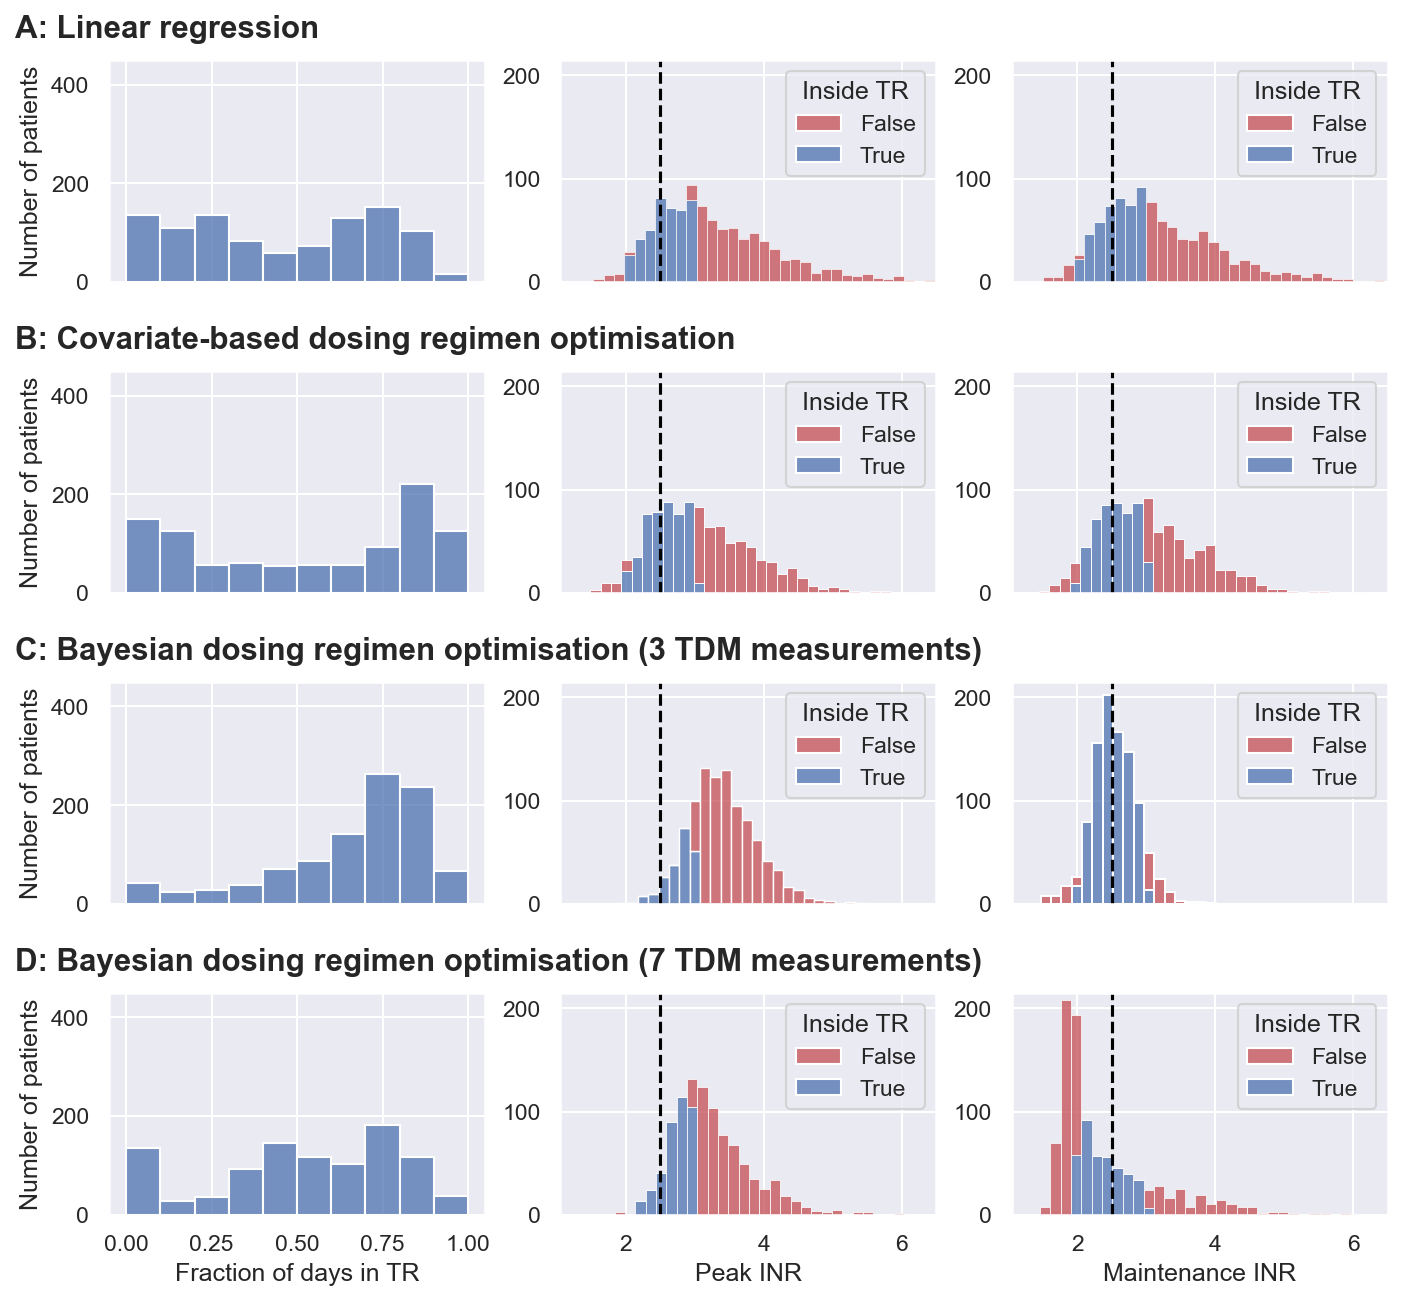

In [86]:
# Visualise results
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 2100 // my_dpi), dpi=150)
outer = gridspec.GridSpec(4, 1, hspace=0.4)

inner1 = gridspec.GridSpecFromSubplotSpec(
    1, 3, subplot_spec=outer[0], wspace=0.2)
inner2 = gridspec.GridSpecFromSubplotSpec(
    1, 3, subplot_spec=outer[1], wspace=0.2)
inner3 = gridspec.GridSpecFromSubplotSpec(
    1, 3, subplot_spec=outer[2], wspace=0.2)
inner4 = gridspec.GridSpecFromSubplotSpec(
    1, 3, subplot_spec=outer[3], wspace=0.2)

# Create axes
axes = []
axes.append(plt.Subplot(fig, inner1[0]))
axes.append(plt.Subplot(fig, inner1[1]))
axes.append(plt.Subplot(fig, inner1[2]))
axes.append(plt.Subplot(fig, inner2[0]))
axes.append(plt.Subplot(fig, inner2[1]))
axes.append(plt.Subplot(fig, inner2[2]))
axes.append(plt.Subplot(fig, inner3[0]))
axes.append(plt.Subplot(fig, inner3[1]))
axes.append(plt.Subplot(fig, inner3[2]))
axes.append(plt.Subplot(fig, inner4[0]))
axes.append(plt.Subplot(fig, inner4[1]))
axes.append(plt.Subplot(fig, inner4[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
in_tr = (inrs_1 >= 2) & (inrs_1 <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[0], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot distribution of peak INR
max_inrs = np.max(inrs_1, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[1], multiple='stack',binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[1].axvline(x=2.5, color='black', linestyle='dashed')

# # Plot maintenance INR distirbution
final_inrs = inrs_1[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[2], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[2].axvline(x=2.5, color='black', linestyle='dashed')

# Plot time in therapeutic range
in_tr = (inrs_2 >= 2) & (inrs_2 <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[3], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot distribution of peak INR
max_inrs = np.max(inrs_2, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[4], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[4].axvline(x=2.5, color='black', linestyle='dashed')

# Plot maintenance INR distirbution
final_inrs = inrs_2[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[5], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[5].axvline(x=2.5, color='black', linestyle='dashed')

# Plot time in therapeutic range
in_tr = (inrs_3 >= 2) & (inrs_3 <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[6], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot distribution of peak INR
max_inrs = np.max(inrs_3, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[7], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[7].axvline(x=2.5, color='black', linestyle='dashed')

# Plot maintenance INR distirbution
final_inrs = inrs_3[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[8], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[8].axvline(x=2.5, color='black', linestyle='dashed')

# Plot time in therapeutic range
in_tr = (inrs_4 >= 2) & (inrs_4 <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[9], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot distribution of peak INR
max_inrs = np.max(inrs_4, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[10], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[10].axvline(x=2.5, color='black', linestyle='dashed')

# # Plot maintenance INR distirbution
final_inrs = inrs_4[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[11], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[11].axvline(x=2.5, color='black', linestyle='dashed')

# Label axes
axes[0].set_xlabel('')
axes[0].set_ylabel('Number of patients')
axes[0].set_xlim([-0.05, 1.05])
axes[0].set_xticklabels(labels=[], visible=False)
axes[0].set_ylim([0, 450])
axes[1].set_xlabel('')
axes[1].set_xticklabels(labels=[], visible=False)
axes[1].set_ylabel('')
axes[1].set_xlim([1.05, 6.5])
axes[1].set_ylim([0, 215])
axes[2].set_xlabel('')
axes[2].set_xticklabels(labels=[], visible=False)
axes[2].set_xlim([1.05, 6.5])
axes[2].set_ylim([0, 215])
axes[2].set_ylabel('')
axes[3].set_xlabel('')
axes[3].set_xticklabels(labels=[], visible=False)
axes[3].set_ylabel('Number of patients')
axes[3].set_xlim([-0.05, 1.05])
axes[3].set_ylim([0, 450])
axes[4].set_xlabel('')
axes[4].set_xticklabels(labels=[], visible=False)
axes[4].set_ylabel('')
axes[4].set_xlim([1.05, 6.5])
axes[4].set_ylim([0, 215])
axes[5].set_xlabel('')
axes[5].set_ylabel('')
axes[5].set_xticklabels(labels=[], visible=False)
axes[5].set_xlim([1.05, 6.5])
axes[5].set_ylim([0, 215])
axes[6].set_xlabel('')
axes[6].set_xticklabels(labels=[], visible=False)
axes[6].set_ylabel('Number of patients')
axes[6].set_xlim([-0.05, 1.05])
axes[6].set_ylim([0, 450])
axes[7].set_xlabel('')
axes[7].set_xticklabels(labels=[], visible=False)
axes[7].set_ylabel('')
axes[7].set_xlim([1.05, 6.5])
axes[7].set_ylim([0, 215])
axes[8].set_xlabel('')
axes[8].set_ylabel('')
axes[8].set_xticklabels(labels=[], visible=False)
axes[8].set_xlim([1.05, 6.5])
axes[8].set_ylim([0, 215])
axes[9].set_xlabel('Fraction of days in TR')
axes[9].set_ylabel('Number of patients')
axes[9].set_xlim([-0.05, 1.05])
axes[9].set_ylim([0, 450])
axes[10].set_xlabel('Peak INR')
axes[10].set_ylabel('')
axes[10].set_xlim([1.05, 6.5])
axes[10].set_ylim([0, 215])
axes[11].set_xlabel('Maintenance INR')
axes[11].set_xlim([1.05, 6.5])
axes[11].set_ylim([0, 215])
axes[11].set_ylabel('')

axes[0].text(
    -0.25, 1.1, string.ascii_uppercase[0] + ': Linear regression', transform=axes[0].transAxes,
    size=15, weight='bold')
axes[3].text(
    -0.25, 1.1, string.ascii_uppercase[1] + ': Covariate-based dosing regimen optimisation', transform=axes[3].transAxes,
    size=15, weight='bold')
axes[6].text(
    -0.25, 1.1, string.ascii_uppercase[2] + ': Bayesian dosing regimen optimisation (3 TDM measurements)', transform=axes[6].transAxes,
    size=15, weight='bold')
axes[9].text(
    -0.25, 1.1, string.ascii_uppercase[3] + ': Bayesian dosing regimen optimisation (7 TDM measurements)', transform=axes[9].transAxes,
    size=15, weight='bold')

# plt.savefig('10_bayesian_mipd.pdf',
#     bbox_inches='tight')
# plt.savefig('10_bayesian_mipd.tif',
#     bbox_inches='tight')

plt.show()

Improve figure

/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attem

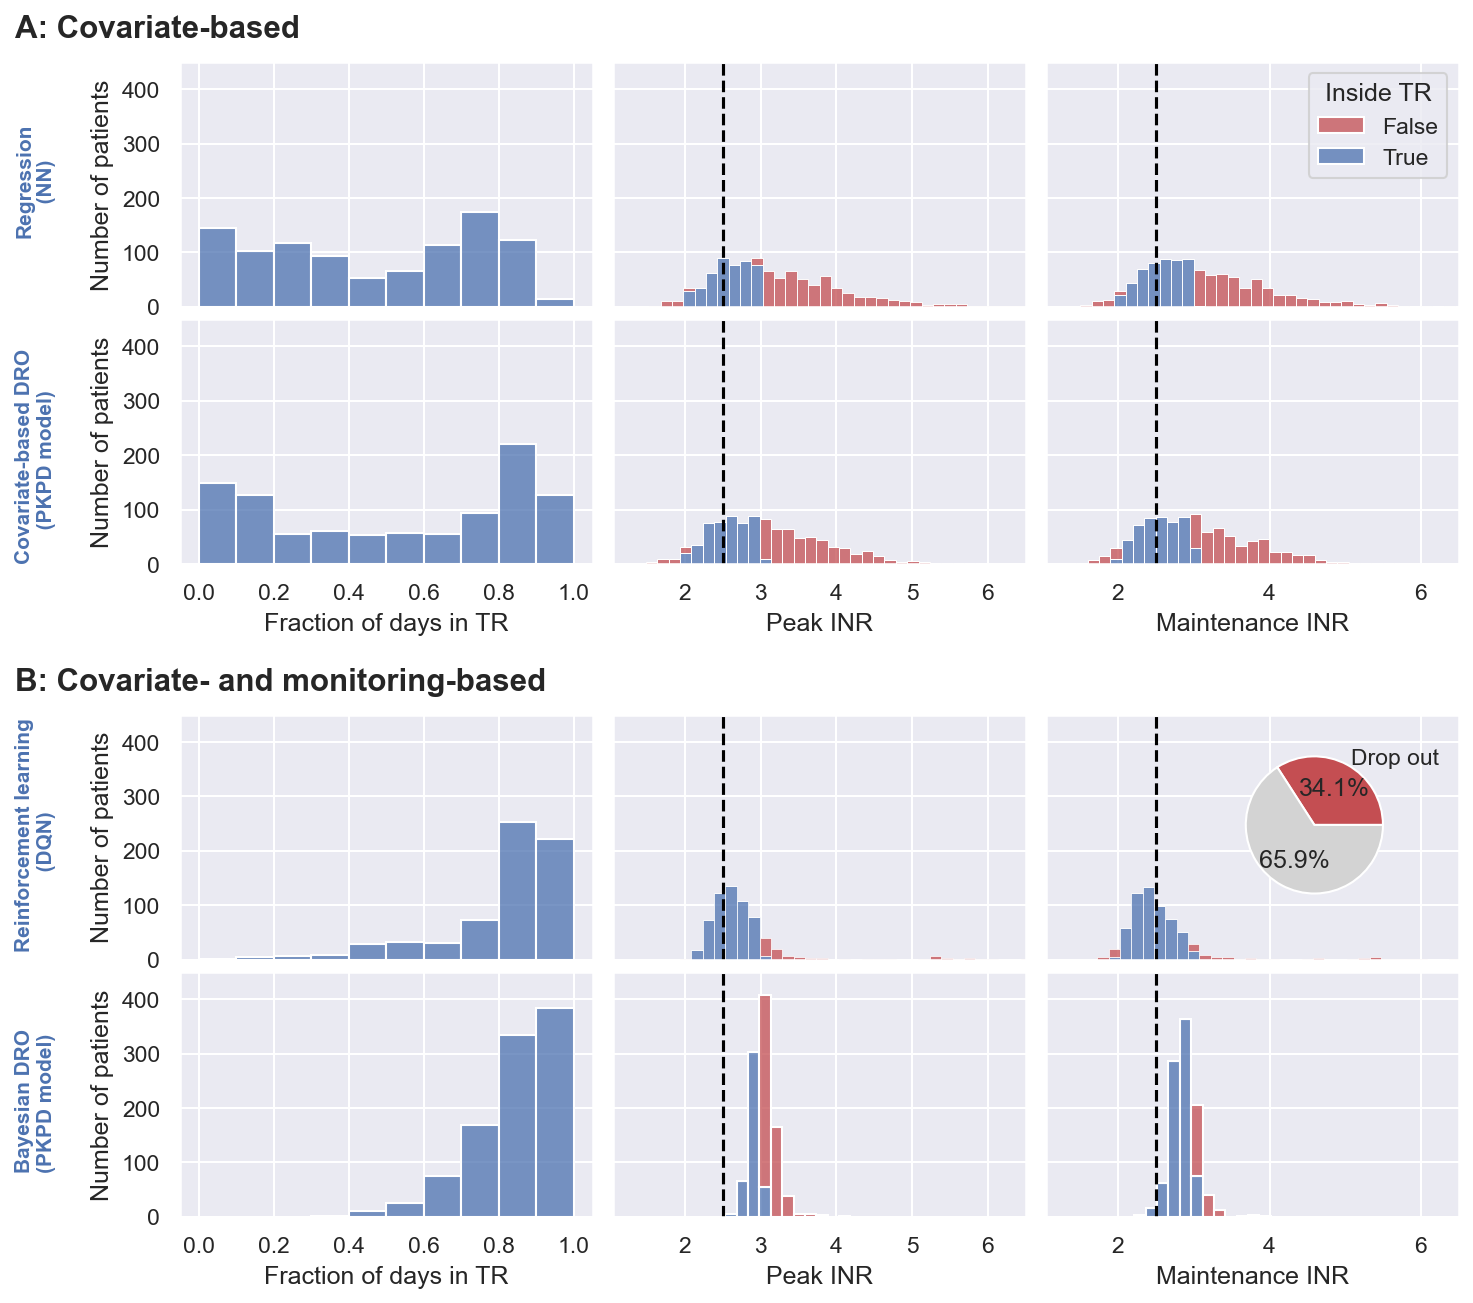

In [38]:
# Visualise results
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 2100 // my_dpi), dpi=150)
outer = gridspec.GridSpec(2, 1, hspace=0.3)

inner1 = gridspec.GridSpecFromSubplotSpec(
    2, 3, subplot_spec=outer[0], wspace=0.05, hspace=0.05)
inner2 = gridspec.GridSpecFromSubplotSpec(
    2, 3, subplot_spec=outer[1], wspace=0.05, hspace=0.05)

# Create axes
axes = []
axes.append(plt.Subplot(fig, inner1[0]))
axes.append(plt.Subplot(fig, inner1[1]))
axes.append(plt.Subplot(fig, inner1[2]))
axes.append(plt.Subplot(fig, inner1[3]))
axes.append(plt.Subplot(fig, inner1[4]))
axes.append(plt.Subplot(fig, inner1[5]))
axes.append(plt.Subplot(fig, inner2[0]))
axes.append(plt.Subplot(fig, inner2[1]))
axes.append(plt.Subplot(fig, inner2[2]))
axes.append(plt.Subplot(fig, inner2[3]))
axes.append(plt.Subplot(fig, inner2[4]))
axes.append(plt.Subplot(fig, inner2[5]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
in_tr = (inrs_1 >= 2) & (inrs_1 <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[0], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot distribution of peak INR
max_inrs = np.max(inrs_1, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[1], multiple='stack',binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]], legend=False)
axes[1].axvline(x=2.5, color='black', linestyle='dashed')

# # Plot maintenance INR distirbution
final_inrs = inrs_1[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[2], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[2].axvline(x=2.5, color='black', linestyle='dashed')

# Plot time in therapeutic range
in_tr = (inrs_2 >= 2) & (inrs_2 <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[3], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot distribution of peak INR
max_inrs = np.max(inrs_2, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[4], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]], legend=False)
axes[4].axvline(x=2.5, color='black', linestyle='dashed')

# Plot maintenance INR distirbution
final_inrs = inrs_2[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[5], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]], legend=False)
axes[5].axvline(x=2.5, color='black', linestyle='dashed')

# Plot time in therapeutic range
in_tr = (inrs_3 >= 2) & (inrs_3 <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[6], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot distribution of peak INR
max_inrs = np.max(inrs_3, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[7], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]], legend=False)
axes[7].axvline(x=2.5, color='black', linestyle='dashed')

# Plot maintenance INR distirbution
final_inrs = inrs_3[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[8], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]], legend=False)
axes[8].axvline(x=2.5, color='black', linestyle='dashed')

# Plot time in therapeutic range
in_tr = (inrs_4 >= 2) & (inrs_4 <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[9], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot distribution of peak INR
max_inrs = np.max(inrs_4, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[10], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]], legend=False)
axes[10].axvline(x=2.5, color='black', linestyle='dashed')

# # Plot maintenance INR distirbution
final_inrs = inrs_4[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[11], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]], legend=False)
axes[11].axvline(x=2.5, color='black', linestyle='dashed')

# Add pie chart for excluded from trial
inset = axes[8].inset_axes([0.3, 0.2, 0.7, 0.7])
inset.pie(
    [len(excluded), 1000 - len(excluded)], labels=['Drop out', ''],
    autopct='%1.1f%%', colors=[sns.color_palette()[3], 'lightgrey'])

# Label axes
axes[0].set_xlabel('')
axes[0].set_ylabel('Number of patients')
axes[0].set_xlim([-0.05, 1.05])
axes[0].set_xticklabels(labels=[], visible=False)
axes[0].set_ylim([0, 450])
axes[1].set_xlabel('')
axes[1].set_xticklabels(labels=[], visible=False)
axes[1].set_yticklabels(labels=[], visible=False)
axes[1].set_ylabel('')
axes[1].set_xlim([1.05, 6.5])
axes[1].set_ylim([0, 450])
axes[2].set_xlabel('')
axes[2].set_xticklabels(labels=[], visible=False)
axes[2].set_yticklabels(labels=[], visible=False)
axes[2].set_xlim([1.05, 6.5])
axes[2].set_ylim([0, 450])
axes[2].set_ylabel('')
axes[3].set_xlabel('Fraction of days in TR')
axes[3].set_ylabel('Number of patients')
axes[3].set_xlim([-0.05, 1.05])
axes[3].set_ylim([0, 450])
axes[4].set_xlabel('Peak INR')
axes[4].set_ylabel('')
axes[4].set_yticklabels(labels=[], visible=False)
axes[4].set_xlim([1.05, 6.5])
axes[4].set_ylim([0, 450])
axes[5].set_xlabel('Maintenance INR')
axes[5].set_ylabel('')
axes[5].set_yticklabels(labels=[], visible=False)
axes[5].set_xlim([1.05, 6.5])
axes[5].set_ylim([0, 450])
axes[6].set_xlabel('')
axes[6].set_xticklabels(labels=[], visible=False)
axes[6].set_ylabel('Number of patients')
axes[6].set_xlim([-0.05, 1.05])
axes[6].set_ylim([0, 450])
axes[7].set_xlabel('')
axes[7].set_xticklabels(labels=[], visible=False)
axes[7].set_yticklabels(labels=[], visible=False)
axes[7].set_ylabel('')
axes[7].set_xlim([1.05, 6.5])
axes[7].set_ylim([0, 450])
axes[8].set_xlabel('')
axes[8].set_ylabel('')
axes[8].set_xticklabels(labels=[], visible=False)
axes[8].set_yticklabels(labels=[], visible=False)
axes[8].set_xlim([1.05, 6.5])
axes[8].set_ylim([0, 450])
axes[9].set_xlabel('Fraction of days in TR')
axes[9].set_ylabel('Number of patients')
axes[9].set_xlim([-0.05, 1.05])
axes[9].set_ylim([0, 450])
axes[10].set_xlabel('Peak INR')
axes[10].set_ylabel('')
axes[10].set_yticklabels(labels=[], visible=False)
axes[10].set_xlim([1.05, 6.5])
axes[10].set_ylim([0, 450])
axes[11].set_xlabel('Maintenance INR')
axes[11].set_yticklabels(labels=[], visible=False)
axes[11].set_xlim([1.05, 6.5])
axes[11].set_ylim([0, 450])
axes[11].set_ylabel('')

axes[0].text(
    -0.4, 1.1, string.ascii_uppercase[0] + ': Covariate-based',
    transform=axes[0].transAxes,
    size=15, weight='bold')
axes[0].text(
    -0.4, 0.3, 'Regression\n      (NN)', transform=axes[0].transAxes,
    size=10, weight='bold', color=sns.color_palette()[0], rotation=90)
axes[3].text(
    -0.4, 0.02, 'Covariate-based DRO\n      (PKPD model)', transform=axes[3].transAxes,
    size=10, weight='bold', color=sns.color_palette()[0], rotation=90)
axes[6].text(
    -0.4, 1.1, string.ascii_uppercase[1] + ': Covariate- and monitoring-based', transform=axes[6].transAxes,
    size=15, weight='bold')
axes[6].text(
    -0.4, 0.05, 'Reinforcement learning\n              (DQN)', transform=axes[6].transAxes,
    size=10, weight='bold', color=sns.color_palette()[0], rotation=90)
axes[9].text(
    -0.4, 0.2, 'Bayesian DRO\n(PKPD model)', transform=axes[9].transAxes,
    size=10, weight='bold', color=sns.color_palette()[0], rotation=90)

plt.savefig('11_mipd_trial_results.pdf',
    bbox_inches='tight')
plt.savefig('11_mipd_trial_results.tif',
    bbox_inches='tight')

plt.show()

Figure without peak INR

/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attem

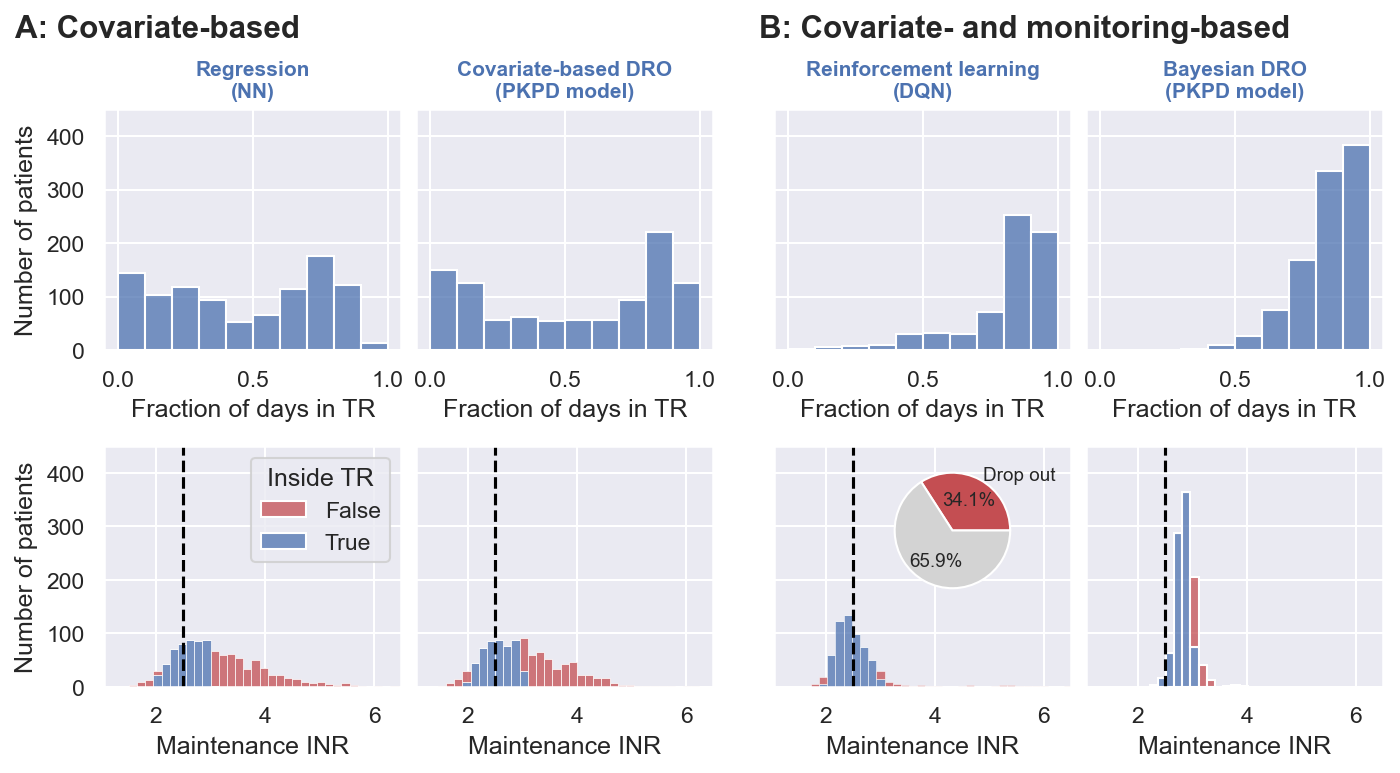

In [89]:
# Visualise results
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1000 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.1)

inner1 = gridspec.GridSpecFromSubplotSpec(
    2, 2, subplot_spec=outer[0], wspace=0.05, hspace=0.4)
inner2 = gridspec.GridSpecFromSubplotSpec(
    2, 2, subplot_spec=outer[1], wspace=0.05, hspace=0.4)

# Create axes
axes = []
axes.append(plt.Subplot(fig, inner1[0]))
axes.append(plt.Subplot(fig, inner1[1]))
axes.append(plt.Subplot(fig, inner1[2]))
axes.append(plt.Subplot(fig, inner1[3]))
axes.append(plt.Subplot(fig, inner2[0]))
axes.append(plt.Subplot(fig, inner2[1]))
axes.append(plt.Subplot(fig, inner2[2]))
axes.append(plt.Subplot(fig, inner2[3]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
in_tr = (inrs_1 >= 2) & (inrs_1 <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[0], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot maintenance INR distirbution
final_inrs = inrs_1[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[2], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[2].axvline(x=2.5, color='black', linestyle='dashed')

# Plot time in therapeutic range
in_tr = (inrs_2 >= 2) & (inrs_2 <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[1], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot maintenance INR distirbution
final_inrs = inrs_2[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[3], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]], legend=False)
axes[3].axvline(x=2.5, color='black', linestyle='dashed')

# Plot time in therapeutic range
in_tr = (inrs_3 >= 2) & (inrs_3 <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[4], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot maintenance INR distirbution
final_inrs = inrs_3[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[6], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]], legend=False)
axes[6].axvline(x=2.5, color='black', linestyle='dashed')

# Plot time in therapeutic range
in_tr = (inrs_4 >= 2) & (inrs_4 <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[5], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot maintenance INR distirbution
final_inrs = inrs_4[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[7], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]], legend=False)
axes[7].axvline(x=2.5, color='black', linestyle='dashed')

# Add pie chart for excluded from trial
inset = axes[6].inset_axes([0.3, 0.35, 0.6, 0.6])
inset.pie(
    [len(excluded), 1000 - len(excluded)], labels=['Drop out', ''],
    autopct='%1.1f%%', colors=[sns.color_palette()[3], 'lightgrey'],
    textprops={'fontsize':int(0.9 * fontsize)})

# Label axes
axes[0].set_xlabel('')
axes[0].set_ylabel('Number of patients')
axes[0].set_xlim([-0.05, 1.05])
axes[0].set_ylim([0, 450])
axes[0].set_xlabel('Fraction of days in TR')
axes[1].set_yticklabels(labels=[], visible=False)
axes[1].set_ylabel('')
axes[1].set_xlim([-0.05, 1.05])
axes[1].set_ylim([0, 450])
axes[1].set_xlabel('Fraction of days in TR')
axes[2].set_xlabel('Maintenance INR')
axes[2].set_ylabel('Number of patients')
axes[2].set_xlim([1.05, 6.5])
axes[2].set_ylim([0, 450])
axes[3].set_xlabel('Maintenance INR')
axes[3].set_ylabel('')
axes[3].set_yticklabels(labels=[], visible=False)
axes[3].set_xlim([1.05, 6.5])
axes[3].set_ylim([0, 450])
axes[4].set_yticklabels(labels=[], visible=False)
axes[4].set_ylabel('')
axes[4].set_xlabel('Fraction of days in TR')
axes[4].set_xlim([-0.05, 1.05])
axes[4].set_ylim([0, 450])
axes[5].set_xlabel('')
axes[5].set_yticklabels(labels=[], visible=False)
axes[5].set_ylabel('')
axes[5].set_xlabel('Fraction of days in TR')
axes[5].set_xlim([-0.05, 1.05])
axes[5].set_ylim([0, 450])
axes[6].set_xlabel('Maintenance INR')
axes[6].set_yticklabels(labels=[], visible=False)
axes[6].set_ylabel('')
axes[6].set_xlim([1.05, 6.5])
axes[6].set_ylim([0, 450])
axes[7].set_xlabel('Maintenance INR')
axes[7].set_yticklabels(labels=[], visible=False)
axes[7].set_xlim([1.05, 6.5])
axes[7].set_ylim([0, 450])
axes[7].set_ylabel('')

axes[0].text(
    -0.3, 1.3, string.ascii_uppercase[0] + ': Covariate-based',
    transform=axes[0].transAxes,
    size=15, weight='bold')
axes[0].set_title(
    'Regression\n(NN)', size=10, weight='bold', color=sns.color_palette()[0])
axes[1].set_title(
    'Covariate-based DRO\n(PKPD model)', size=10, weight='bold',
    color=sns.color_palette()[0])
axes[4].text(
    -0.05, 1.3, string.ascii_uppercase[1] + ': Covariate- and monitoring-based',
    transform=axes[4].transAxes,
    size=15, weight='bold')
axes[4].set_title(
    'Reinforcement learning\n(DQN)', size=10, weight='bold',
    color=sns.color_palette()[0])
axes[5].set_title(
    'Bayesian DRO\n(PKPD model)', size=10, weight='bold',
    color=sns.color_palette()[0])

plt.savefig('11_mipd_trial_results_simplified.pdf',
    bbox_inches='tight')
plt.savefig('11_mipd_trial_results_simplified.tif',
    bbox_inches='tight')

plt.show()

## Understanding DQN

In [327]:
# Load policy
directory = os.path.dirname(os.getcwd())
data = pd.read_csv(
    directory + '/4_reinforcement_learning'
    '/policy_no_IIV.csv')
policy_1 = data[['INR', 'Dose']].values

# Load maintenance distribution
directory = os.path.dirname(os.getcwd())
df_doses = pd.read_csv(
    directory + '/4_reinforcement_learning'
    '/mipd_trial_predicted_dosing_regimens_no_IIV.csv')
df_doses = df_doses[df_doses['Number of observations'] == 19]
inrs_dqn_1 = df_doses.INR.values

# Load policy
directory = os.path.dirname(os.getcwd())
data = pd.read_csv(
    directory + '/4_reinforcement_learning'
    '/policy_no_unexplained_IIV.csv')
policy_2 = {}
for idx in range(3):
    if idx == 0:
        label = 'GG'
        temp = data[data['VKORC1 G alleles'] == 1]
    elif idx == 1:
        label = 'GA'
        temp = data[data['VKORC1 G alleles'] == 0.5]
    else:
        label = 'AA'
        temp = data[data['VKORC1 G alleles'] == 0]

    policy_2[label] = temp[['INR', 'Dose']].values

# Load maintenance distribution
directory = os.path.dirname(os.getcwd())
df_doses = pd.read_csv(
    directory + '/4_reinforcement_learning'
    '/mipd_trial_predicted_dosing_regimens_no_unexplained_IIV.csv')
df_doses = df_doses[df_doses['Number of observations'] == 19]
inrs_dqn_2 = df_doses.INR.values

# Load policy
directory = os.path.dirname(os.getcwd())
data = pd.read_csv(
    directory + '/4_reinforcement_learning'
    '/policy_no_explained_IIV.csv')
policy_3 = data[['INR', 'Dose']].values

# Load maintenance distribution
directory = os.path.dirname(os.getcwd())
df_doses = pd.read_csv(
    directory + '/4_reinforcement_learning'
    '/mipd_trial_predicted_dosing_regimens_no_explained_IIV.csv')
df_doses = df_doses[df_doses['Number of observations'] == 19]
inrs_dqn_3 = df_doses.INR.values

/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attem

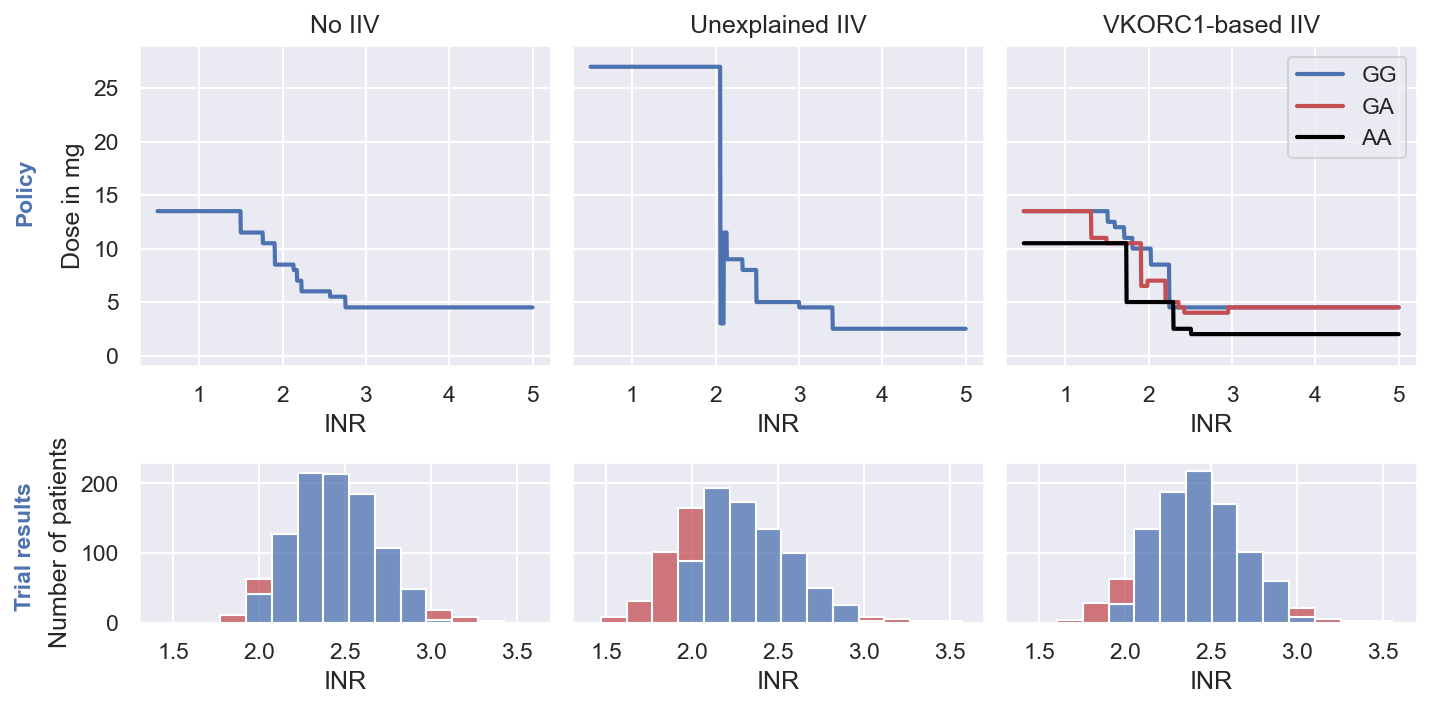

In [329]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1000 // my_dpi), dpi=150)
outer = gridspec.GridSpec(2, 3, wspace=0.05, hspace=0.4, height_ratios=[2, 1])

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[2]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[3]))
axes.append(plt.Subplot(fig, outer[5]))
axes.append(plt.Subplot(fig, outer[4]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

axes[0].plot(policy_1[:, 0], policy_1[:, 1], linewidth=2)
df = pd.DataFrame({
    'INR': inrs_dqn_1, 'Inside TR': (inrs_dqn_1>=2) & (inrs_dqn_1<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[3], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]], legend=False)

colors = [sns.color_palette()[0], sns.color_palette()[3], 'black']
for idl, label in enumerate(policy_2.keys()):
    axes[1].plot(
        policy_2[label][:, 0], policy_2[label][:, 1], label=label,
        color=colors[idl], linewidth=2)
df = pd.DataFrame({
    'INR': inrs_dqn_2, 'Inside TR': (inrs_dqn_2>=2) & (inrs_dqn_2<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[4], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]], legend=False)

axes[2].plot(policy_3[:, 0], policy_3[:, 1], linewidth=2)
df = pd.DataFrame({
    'INR': inrs_dqn_3, 'Inside TR': (inrs_dqn_3>=2) & (inrs_dqn_3<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[5], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]], legend=False)

# Label axes
axes[0].set_xlabel('INR')
axes[0].set_ylabel('Dose in mg')
axes[0].set_title('No IIV')
axes[0].set_ylim([-1, 29])
axes[1].set_xlabel('INR')
axes[1].set_yticklabels(labels=[], visible=False)
axes[1].set_ylabel('')
axes[1].set_title('VKORC1-based IIV')
axes[1].set_ylim([-1, 29])
axes[2].set_ylabel('')
axes[2].set_yticklabels(labels=[], visible=False)
axes[2].set_xlabel('INR')
axes[2].set_title('Unexplained IIV')
axes[2].set_ylim([-1, 29])
axes[3].set_ylabel('Number of patients')
axes[3].set_xlim([1.3, 3.7])
axes[3].set_ylim([0, 230])
axes[4].set_yticklabels(labels=[], visible=False)
axes[4].set_ylabel('')
axes[4].set_xlim([1.3, 3.7])
axes[4].set_ylim([0, 230])
axes[5].set_yticklabels(labels=[], visible=False)
axes[5].set_ylabel('')
axes[5].set_xlim([1.3, 3.7])
axes[5].set_ylim([0, 230])

axes[0].text(
    -0.3, 0.45, 'Policy', transform=axes[0].transAxes,
    size=11, weight='bold', color=sns.color_palette()[0], rotation=90)
axes[3].text(
    -0.3, 0.1, 'Trial results', transform=axes[3].transAxes,
    size=11, weight='bold', color=sns.color_palette()[0], rotation=90)

axes[1].legend()

plt.savefig('12_dqn_dosing_policy.pdf',
    bbox_inches='tight')
plt.savefig('12_dqn_dosing_policy.tif',
    bbox_inches='tight')

plt.show()

## Predictive performance of BDRO

In [97]:
# Define model
model, _ = define_wajima_model(patient=True, inr_test=True)

# Get patient parameters
ids = df_demo.ID.dropna().unique()
parameters = np.empty(shape=(len(ids), model.n_parameters()))
for idx, _id in enumerate(ids):
    temp = df_demo[df_demo.ID == _id]
    parameters[idx] = temp[model.parameters()].values[0]

# Define IOV and EV
ids = df_doses.ID.dropna().unique()
rng = np.random.default_rng(seed=4)
delays = rng.exponential(scale=0.5, size=(days, len(ids)))
vk_input = get_vk_consumption(days, len(ids), seed=14)

n_data = np.arange(0, 20)
run = 0
try:
    run = len(inr_sequence)
except NameError:
    inr_sequence = []
for n in n_data:
    if n < run:
        continue
    # Load dosing strategy
    directory = os.path.dirname(os.getcwd())
    df_doses = pd.read_csv(
        directory + '/2_semi_mechanistic_model'
        '/mipd_trial_predicted_dosing_regimens.csv')
    df_doses = df_doses[df_doses['Number of observations'] == n]

    # Convert dosing strategy to dosing regimens
    days = 19
    cal_time = 100 * 24
    duration = 0.01
    dosing_regimens = {}
    doses = np.empty(shape=(len(df_doses.ID.dropna().unique()), days))
    for idx, _id in enumerate(df_doses.ID.dropna().unique()):
        temp = df_doses[df_doses.ID == _id]
        doses[idx] = \
            temp[['Dose %d in mg' % (idx+1) for idx in range(days)]].values[0]

    # Simulate INR response to treatment
    times = cal_time + np.linspace(0, days, 100, endpoint=False) * 24
    sim = np.empty(shape=(len(ids), len(times)))
    for idx, _id in enumerate(ids):
        # Set dosing regimen
        dr = define_dosing_regimen(doses[idx], delays=delays[:, idx])
        model.set_dosing_regimen(dr)

        # Simulate treatment response
        mask = ids == _id
        sim[idx] = model.simulate(
            parameters=parameters[mask][0],
            times=times, vk_input=vk_input[:, idx])

    inr_sequence.append(sim[:, -1])

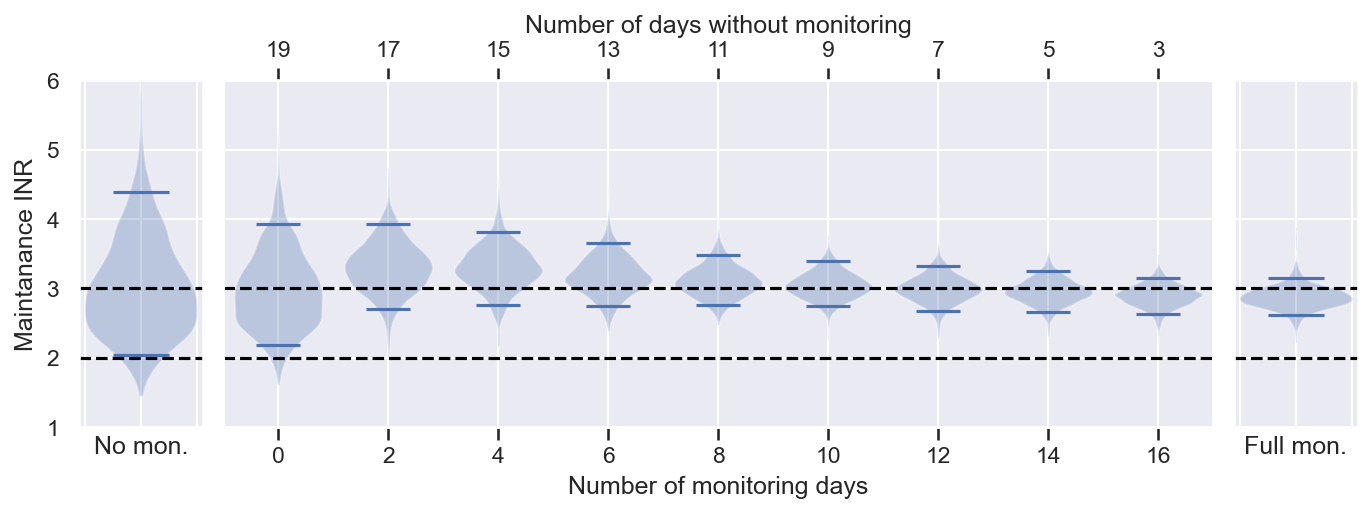

In [140]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, width_ratios=[1, len(n_data)/2-2, 1], wspace=0.05)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

axes[0].axhline(3, color='black', linestyle='dashed')
axes[0].axhline(2, color='black', linestyle='dashed')
axes[1].axhline(3, color='black', linestyle='dashed')
axes[1].axhline(2, color='black', linestyle='dashed')
axes[2].axhline(3, color='black', linestyle='dashed')
axes[2].axhline(2, color='black', linestyle='dashed')

axes[0].set_ylim([1, 6])
axes[0].set_ylabel('Maintanance INR')
axes[0].set_xlabel('No mon.')
axes[0].set_xticklabels(labels=[], visible=False)
axes[1].set_ylim([1, 6])
axes[1].set_ylabel('')
axes[1].set_xlim([-1, 17])
axes[1].set_yticklabels(labels=[], visible=False)
axes[1].set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16])
axes[1].set_xlabel('Number of monitoring days')
axes[1].annotate('TR', xy=(n_data[-1]-0.6, 2.1))
axes[2].set_ylim([1, 6])
axes[2].set_xlabel('Full mon.')
axes[2].set_yticklabels(labels=[], visible=False)
axes[2].set_xticklabels(labels=[], visible=False)

# Add a second x axis on top
ax_top = axes[1].twiny()
ax_top.set_xlim(axes[1].get_xlim())
ax_top.set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16])
ax_top.set_xticklabels(19 - np.array([0, 2, 4, 6, 8, 10, 12, 14, 16]))
ax_top.grid(False)
ax_top.set_xlabel('Number of days without monitoring')

axes[1].violinplot(
    inr_sequence[1:-1:2], n_data[1:-1:2] - 1, showextrema=False,
    quantiles=[[0.05, 0.95]] * len(inr_sequence[1:-1:2]),
    widths=[1.6] * len(inr_sequence[1:-1:2]))
axes[0].violinplot(
    [inr_sequence[0]], [-1], showextrema=False, quantiles=[[0.05, 0.95]])
axes[2].violinplot(
    [inr_sequence[-1]], [19], showextrema=False, quantiles=[[0.05, 0.95]])

plt.savefig('13_bdro_over_time.pdf',
    bbox_inches='tight')
plt.savefig('13_bdro_over_time.tif',
    bbox_inches='tight')

plt.show()